# Traffic Sign Recognition Classifier

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from tensorflow import keras
import tensorflow.contrib.eager as tfe

import numpy as np

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.9.0-rc0
Eager execution: True


---

## The German Traffic Sign Recognition Benchmark [*](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)

The below code assumes dataset files are placed in ./data folder and in specific subfolders of ./data

A convenience dataset download script `download_dataset.ssh` is included in this project directory, use this script to download the German Traffic Sign dataset.

---

## Step 0: Load The Data

`dataset` is a dictionary of dictionary with the following structure
<code style="background-color: #fff; font-size: 11px; line-height: 3px;">
    dataset = {
        'train' : {
            'X' : python-list of Image FileName Strings
            'y' : python-list of corresponding class name numbers
        }
        'val' : {
            'X' : python-list of Image FileName Strings
            'y' : python-list of corresponding class name numbers
        }
        'test' : {
            'X' : python-list of Image FileName Strings
            'y' : python-list of corresponding class name numbers
        }
    }
</code>

`train_dataset`, `val_dataset` and `test_dataset` are tf.data objects

`repeat()` is used so that tf.data iterator does not run out of training examples or so that iterator behaves like a circular list



In [2]:
from utils import *

_BATCH_SIZE = 32
_NUM_CLASS = 43
_IMG_SHAPE = (32, 32, 3)

init_global_vars(_NUM_CLASS, _IMG_SHAPE, _BATCH_SIZE)

dataset = get_traffic_sign_dataset();

---

## Step 1: Dataset Summary & Exploration

In [3]:
print("Number of training   examples =", len(dataset["train"]["X"]))
print("Number of validation examples =", len(dataset["val"]["X"]))
print("Number of testing    examples =", len(dataset["test"]["X"]))

print("\n")
print("Image data shape  =", _IMG_SHAPE)
print("Number of classes =", _NUM_CLASS)

Number of training   examples = 35288
Number of validation examples = 3921
Number of testing    examples = 12630


Image data shape  = (32, 32, 3)
Number of classes = 43


In [4]:
class_name_dict = get_class_name_dict()

for k, v in class_name_dict.items():
    print("{:03d}, {:s}".format(k, v))

000, Speed limit (20km/h)
001, Speed limit (30km/h)
002, Speed limit (50km/h)
003, Speed limit (60km/h)
004, Speed limit (70km/h)
005, Speed limit (80km/h)
006, End of speed limit (80km/h)
007, Speed limit (100km/h)
008, Speed limit (120km/h)
009, No passing
010, No passing for vehicles over 3.5 metric tons
011, Right-of-way at the next intersection
012, Priority road
013, Yield
014, Stop
015, No vehicles
016, Vehicles over 3.5 metric tons prohibited
017, No entry
018, General caution
019, Dangerous curve to the left
020, Dangerous curve to the right
021, Double curve
022, Bumpy road
023, Slippery road
024, Road narrows on the right
025, Road work
026, Traffic signals
027, Pedestrians
028, Children crossing
029, Bicycles crossing
030, Beware of ice/snow
031, Wild animals crossing
032, End of all speed and passing limits
033, Turn right ahead
034, Turn left ahead
035, Ahead only
036, Go straight or right
037, Go straight or left
038, Keep right
039, Keep left
040, Roundabout mandatory
0

### Visualization of the dataset

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path

%matplotlib inline

plt.rcParams["figure.figsize"] = [16, 9]
plt.tight_layout()

<Figure size 1152x648 with 0 Axes>

In [27]:
# https://matplotlib.org/gallery/api/histogram_path.html#sphx-glr-gallery-api-histogram-path-py

def plot_bar_chart(bar_heights, title = "", xlabel = "", ylabel = "", fileName = None):
    fig, ax = plt.subplots()
    bins = np.arange(bar_heights.shape[0] + 1)
     
    # get the corners of the rectangles for the histogram
    left = np.array(bins[:-1])
    right = np.array(bins[1:])
    bottom = np.zeros(len(left))
    top = bottom + bar_heights
    
    # we need a (numrects x numsides x 2) numpy array for the path helper
    # function to build a compound path
    XY = np.array([[left, left, right, right], [bottom, top, top, bottom]]).T

    # get the Path object
    barpath = path.Path.make_compound_path_from_polys(XY)

    # make a patch out of it
    patch = patches.PathPatch(barpath)
    ax.add_patch(patch)

    width = right[0] - left[0]
    # Hide major tick labels
    ax.set_xticklabels('')

    # Customize minor tick labels
    ax.set_xticks(bins + width / 2.0, minor=True)
    ax.set_xticklabels(bins, minor=True)
    ax.set_xticks(bins)
    
    # update the view limits
    ax.set_xlim(left[0], right[-1])
    ax.set_ylim(bottom.min(), top.max())
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    # plt.grid(True)
    
    if fileName is None:
        plt.show()
    else:
        fig.savefig(fileName, bbox_inches = 'tight')
        # closing the plot is important or else the any previous plot's
        # will be shown in output 
        plt.close()

    
def plot_histogram(bars, title, xlabel = "Class Number", ylabel = "Class Count"):
    bar_heights = np.bincount(bars, minlength = _NUM_CLASS)
    plot_bar_chart(bar_heights, title, xlabel, ylabel)
    
    


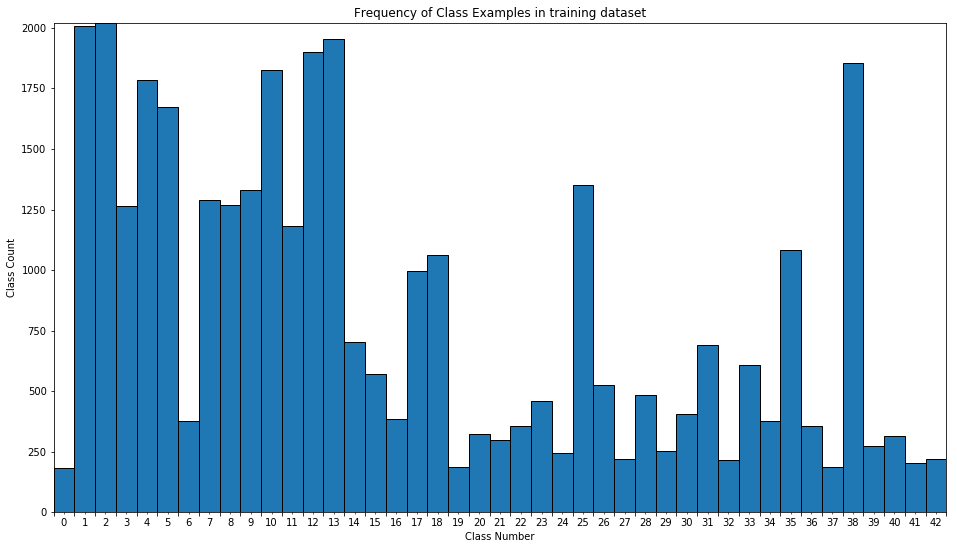

In [7]:
plot_histogram(dataset["train"]["y"], 'Frequency of Class Examples in training dataset')

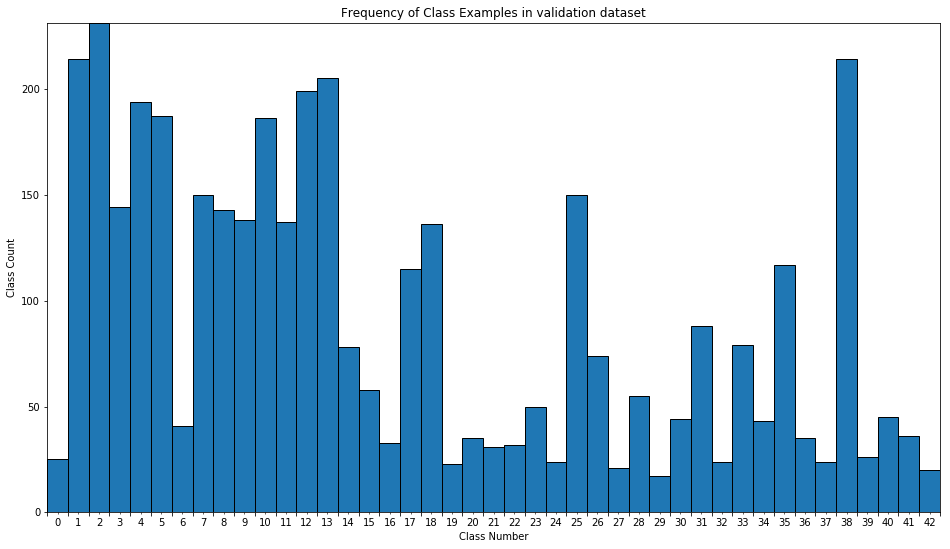

In [8]:
plot_histogram(dataset["val"]["y"], 'Frequency of Class Examples in validation dataset')

----

## Step 2: Generating Tensorflow Datasets

### Pre-process the Data Set

### [Normalization](https://en.wikipedia.org/wiki/Normalization_%28image_processing%29)

Normalization transforms an n-dimensional grayscale image $I:\{{\mathbb  {X}}\subseteq {\mathbb  {R}}^{n}\}\rightarrow \{{\text{Min}},..,{\text{Max}}\}$ with intensity values in the range (Min, Max), into a new image $I_{N}:\{{\mathbb  {X}}\subseteq {\mathbb  {R}}^{n}\}\rightarrow \{{\text{newMin}},..,{\text{newMax}}\}$ with intensity values in the range (newMin, newMax).

The linear normalization of a grayscale digital image is performed according to the formula.

$I_{N}=(I-{\text{Min}}){\frac  {{\text{newMax}}-{\text{newMin}}}{{\text{Max}}-{\text{Min}}}}+{\text{newMin}}$

In [9]:
train_dataset = covert_to_tf_dataset(dataset["train"])
val_dataset = covert_to_tf_dataset(dataset["val"])
test_dataset =  covert_to_tf_dataset(dataset["test"])

# next(iter(train_dataset))

----

## Step 2: LeNet-5 Neural network architecture

### Model Architecture

In [10]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Dropout
from tensorflow.keras.initializers import TruncatedNormal

μ = 0.0
σ = 0.05

'''
:::: Defaults ::::
      Conv2D: padding='valid', strides=(1, 1), use_bias=True, bias_initializer='zeros'
MaxPooling2D: pool_size=(2, 2), strides=None, padding='valid'
       Dense: use_bias=True, bias_initializer='zeros'
'''

model = Sequential()

# Input doesn't return a layer
# if you are using Sequential, you may also skip the Input
# and just specify the input_shape for the first Layer.
# model.add(Input(shape=(32, 32, 3)))

# In: (?, 32, 32, 3) | Out: (?, 28, 28, 6)
model.add(Conv2D(6, (5, 5), activation='relu', kernel_initializer=TruncatedNormal(mean=μ, stddev=σ), name='conv1'))
# In: (?, 28, 28, 6) | Out: (?, 14, 14, 6)
model.add(MaxPooling2D(strides=(2, 2), name='conv1_max_p'))
model.add(Dropout(0.3))

# In: (?, 14, 14, 6) | Out: (?, 10, 10, 16)
model.add(Conv2D(16, (5, 5), activation='relu', kernel_initializer=TruncatedNormal(mean=μ, stddev=σ), name='conv2'))
# In: (?, 10, 10, 16) | Out: (?, 5, 5, 16)
model.add(MaxPooling2D(strides=(2, 2), name='conv2_max_p'))
model.add(Dropout(0.3))

# In: (?, 5, 5, 16) | Out: (?, 400) {400 = 5*5*16}
model.add(Flatten(name='flatten'))

# In: (?, 400) | Out: (?, 120)
model.add(Dense(120, activation='relu', kernel_initializer=TruncatedNormal(mean=μ, stddev=σ), name='fc1'))
model.add(Dropout(0.5))

# In: (?, 120) | Out: (?, 84)
model.add(Dense(84, activation='relu', kernel_initializer=TruncatedNormal(mean=μ, stddev=σ), name='fc2'))
model.add(Dropout(0.5))

# In: (?, 84) | Out: (?, num_classes)
model.add(Dense(_NUM_CLASS, activation='softmax', kernel_initializer=TruncatedNormal(mean=μ, stddev=σ), name='fc3'))

- categorical_crossentropy should be used when labels are one_hot_encoded
- sparse_categorical_crossentropy for numbered labels

In [11]:
model.compile(optimizer=tf.train.AdamOptimizer(3e-4), loss='categorical_crossentropy', metrics=['accuracy'])

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing.
A low accuracy on the training and validation sets imply underfitting.
A high accuracy on the training set but low accuracy on the validation set implies overfitting.

#### model.fit() and model.evaluate()

when using tf.data as input make sure to include steps parameter

In [12]:
import pickle
import os

_EPOCHS = 50
_LOAD_MODEL = True

_MODEL_FILE = "./model/checkpoints/model_chkpt"
_HISTORY_FILE = "./model/train_history/train_history_dict.p"

history = None

if not _LOAD_MODEL:
    historyObj = model.fit(
        train_dataset,
        steps_per_epoch = len(dataset["train"]["X"]) // _BATCH_SIZE,
        epochs = _EPOCHS,
        validation_data = val_dataset,
        validation_steps = len(dataset["val"]["X"]) // _BATCH_SIZE,
        verbose = 1
    )
    history = historyObj.history
    
    model.summary()
    
    os.system("spd-say 'Model Trained'")
    
    model.save_weights(_MODEL_FILE)
    print("Saved model weights to disk")
    
    with open(_HISTORY_FILE, 'wb') as f:
        pickle.dump(history, f)
    print("Training history saved")
    
else:
    model.load_weights(_MODEL_FILE)
    print("Model weights loaded from disk")

    with open(_HISTORY_FILE, 'rb') as f:
        history = pickle.load(f)
    print("Training history loaded from disk")


Model weights loaded from disk
Training history loaded from disk


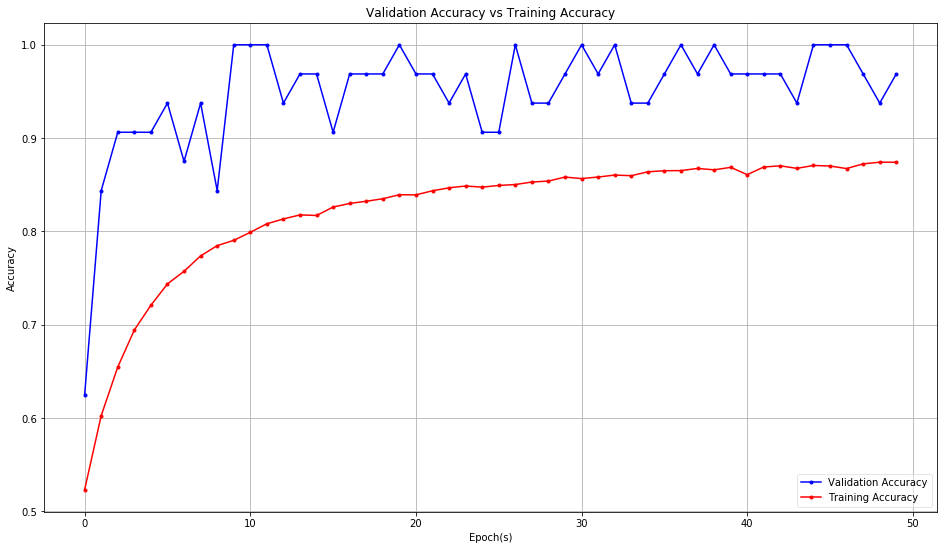

In [13]:
epochs = np.arange(_EPOCHS)

plt.plot(epochs, history['val_acc'], 'b.-', label = "Validation Accuracy")
plt.plot(epochs, history['acc'], 'r.-', label = "Training Accuracy")
plt.title('Validation Accuracy vs Training Accuracy')
plt.xlabel('Epoch(s)')
plt.ylabel('Accuracy')
leg = plt.legend(loc = 'lower right')
leg.get_frame().set_alpha(0.5)
plt.grid(True)
plt.show()
plt.close()

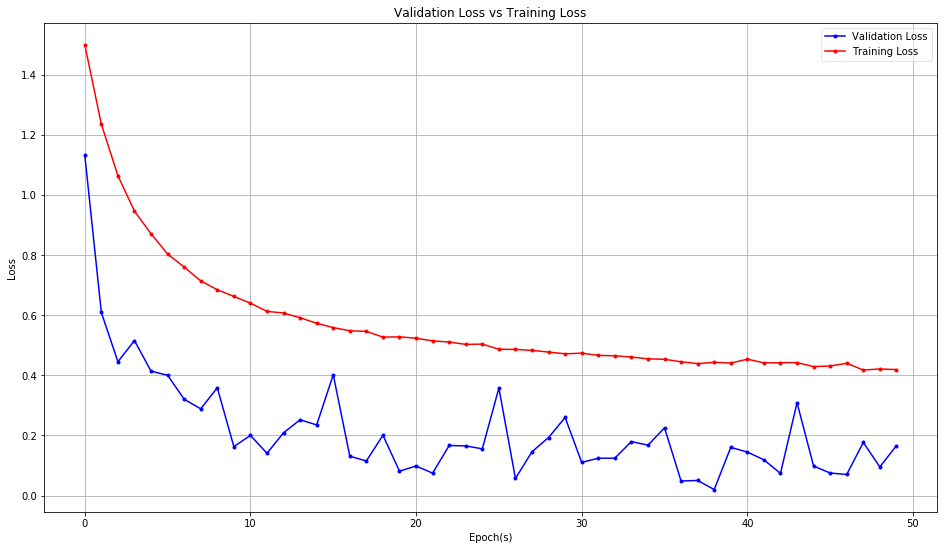

In [14]:
plt.plot(epochs, history['val_loss'], 'b.-', label = "Validation Loss")
plt.plot(epochs, history['loss'], 'r.-', label = "Training Loss")
plt.title('Validation Loss vs Training Loss')
plt.xlabel('Epoch(s)')
plt.ylabel('Loss')
leg = plt.legend(loc = 'upper right')
leg.get_frame().set_alpha(0.5)
plt.grid(True)
plt.show()
plt.close()

#### To plot Model Arch, the following packages need to be installed, pydot, pydot-ng & graphviz

`pip3 install pydot --user`

`pip3 install graphviz --user`

`pip3 install pydot-ng --user`

In [15]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, show_shapes=True, to_file='./model/model_arch.png')

# from IPython.display import SVG
# from tensorflow.keras.utils.vis_utils import model_to_dot
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

---

## Step 3: Testing the Model

In [16]:
test_loss, test_acc = model.evaluate(test_dataset, steps = len(dataset["test"]["X"]) // _BATCH_SIZE)

print('\n')
print('Test set loss:', test_loss)
print('Test set accuracy:', test_acc)

  1/394 [..............................] - ETA: 46s

Test set loss: 0.08390335738658905
Test set accuracy: 0.9375


To get more insight into how our model is working, we downloaded few pictures of German traffic signs from the web and used our model to predict the traffic sign type.

### Load Dataset

In [17]:
example_db = get_examples_dataset()
example_tf_db = covert_to_tf_dataset(example_db, repeat = False)

### Predict the Sign Type for Each Image

In [18]:
predictions = model.predict(example_tf_db, steps = _BATCH_SIZE)
print(predictions.shape)

(18, 43)


### Analyze Performance

[`tf.nn.top_k`](https://www.tensorflow.org/api_docs/python/tf/nn/top_k)

In [19]:
top_k = 5
values, indices = tf.nn.top_k(predictions, k = top_k, sorted = True)
values = values.numpy()
indices = indices.numpy()

<p>Css Styles</p>

<style></style>

The following cell will generate an HTML table to easily compared the predictions of our model. The last column of the plot shows the bar chart of class confidence, to see full size plot.

- Right click on the bar chart
- Copy Image Location
- Open this Image location in a new browser tab/window

OR (If this option is available) Directly open image in new tab/window

In [29]:
N, K = values.shape
correct_pred_count = 0

from IPython.core.display import display, HTML

htmlMarkup = "<table>"
htmlMarkup += "<tr>"
htmlMarkup += "<th>Class#</th>"
htmlMarkup += "<th>Image</th>"
htmlMarkup += "<th>Label</th>"
htmlMarkup += "<th>Model Top {:d} Predictions</th>".format(top_k)
htmlMarkup += "<th>All Predictions</th>"
htmlMarkup += "</tr>"

for n in np.arange(N):
    correct_pred = False
    if indices[n][0] == example_db["y"][n]:
        correct_pred = True
        correct_pred_count = (correct_pred_count + 1)
    
    style = "style='color: red;'" if not correct_pred else ""
    htmlMarkup += "<tr {}>".format(style)
    htmlMarkup += "<td>{}</td>".format(example_db["y"][n])
    htmlMarkup += "<td><img src='{}' height='128' width='128'/></td>".format(example_db["X"][n])
    htmlMarkup += "<td>{}</td>".format(class_name_dict[example_db["y"][n]])
    
    s = ""
    for k in np.arange(K):
        s += "<p>{:5.4f}, {} ({})</p>".format(values[n][k], class_name_dict[indices[n][k]], indices[n][k])
    htmlMarkup += "<td>{}</td>".format(s)
    
    x = example_db["X"][n].rfind("/")
    y = example_db["X"][n].rfind(".")
    fileName = "./plots/" + example_db["X"][n][x + 1 : y] + ".png"
    plot_bar_chart(predictions[n], "", "class num", "confidence", fileName)
    htmlMarkup += "<td><img src='{}' height='128' width='256'/></td>".format(fileName)
    htmlMarkup += "</tr>"

htmlMarkup += "</table>"

display(HTML(htmlMarkup))

print("{}/{} correctly classfified with an accuracy of {:5.4f}".format(correct_pred_count, N, correct_pred_count/N))

Class#,Image,Label,Model Top 5 Predictions,All Predictions
13,,Yield,"0.9999, Yield (13)0.0001, Priority road (12)0.0000, No entry (17)0.0000, End of all speed and passing limits (32)0.0000, No vehicles (15)",
1,,Speed limit (30km/h),"0.8400, Speed limit (30km/h) (1)0.0523, Speed limit (80km/h) (5)0.0414, Speed limit (20km/h) (0)0.0261, Speed limit (50km/h) (2)0.0167, Speed limit (100km/h) (7)",
5,,Speed limit (80km/h),"0.3617, Speed limit (80km/h) (5)0.3438, Speed limit (50km/h) (2)0.2780, Speed limit (30km/h) (1)0.0133, Speed limit (100km/h) (7)0.0021, Speed limit (70km/h) (4)",
25,,Road work,"1.0000, Road work (25)0.0000, Dangerous curve to the right (20)0.0000, Beware of ice/snow (30)0.0000, Bicycles crossing (29)0.0000, Double curve (21)",
13,,Yield,"1.0000, Yield (13)0.0000, Priority road (12)0.0000, No vehicles (15)0.0000, Children crossing (28)0.0000, End of all speed and passing limits (32)",
25,,Road work,"0.4095, General caution (18)0.3028, Traffic signals (26)0.0817, Road work (25)0.0743, Stop (14)0.0361, Bumpy road (22)",
25,,Road work,"0.8055, Road work (25)0.0345, Dangerous curve to the right (20)0.0235, Bicycles crossing (29)0.0225, Beware of ice/snow (30)0.0194, Right-of-way at the next intersection (11)",
11,,Right-of-way at the next intersection,"0.9997, Right-of-way at the next intersection (11)0.0002, Beware of ice/snow (30)0.0001, Double curve (21)0.0000, Pedestrians (27)0.0000, Children crossing (28)",
4,,Speed limit (70km/h),"0.7325, Speed limit (70km/h) (4)0.2144, Speed limit (20km/h) (0)0.0528, Speed limit (30km/h) (1)0.0002, Speed limit (50km/h) (2)0.0000, Speed limit (120km/h) (8)",
13,,Yield,"1.0000, Yield (13)0.0000, Priority road (12)0.0000, No vehicles (15)0.0000, Children crossing (28)0.0000, No entry (17)",


13/18 correctly classfified with an accuracy of 0.7222


---

## Step 4: Visualize the Neural Network's State with Test Images

In [21]:
import math

"""
activation should be of shape (1, H, W, C)
plt_num: used to plot out multiple different weight feature map sets on the same block,
        just extend the plt number for each new feature map entry

"""

def visualize_conv_layer_out(activation, activation_min = -1, activation_max = -1, plt_num = 1):
    _, H, W, C = activation.shape
    num_cols = math.floor(84 / H)
    num_rows = math.ceil(H / num_cols)
    plt.figure(plt_num, figsize=(num_rows, num_cols))

    featuremaps = activation.shape[3]
    plt.figure(figsize = (20, int(num_rows * H / 4.5))) # (width, height)
    
    for c in np.arange(C):
        # sets the number of feature maps to show on each row and column
        plt.subplot(num_rows, num_cols, c + 1)
        plt.axis('off')
        # displays the feature map number
        plt.title('Feature Map ' + str(c))
        
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, c], interpolation="nearest", vmin = activation_min,
                       vmax = activation_max, cmap = "gray")
        
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, c], interpolation="nearest", vmax = activation_max, cmap="gray")
        
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, c], interpolation="nearest", vmin=activation_min, cmap="gray")
        
        else:
            plt.imshow(activation[0,:,:, c], interpolation="nearest", cmap="gray")
    
    plt.show()
    plt.close()

In [22]:
# https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer

def get_intermediate_layer_output(layer_name, x_test):
    layer = model.get_layer(name = layer_name)
    intermediate_layer_model = keras.Model(inputs = model.input, outputs = layer.output)
    return intermediate_layer_model.predict(x_test)

#### Plotting Convolutions of   'N'  random test images

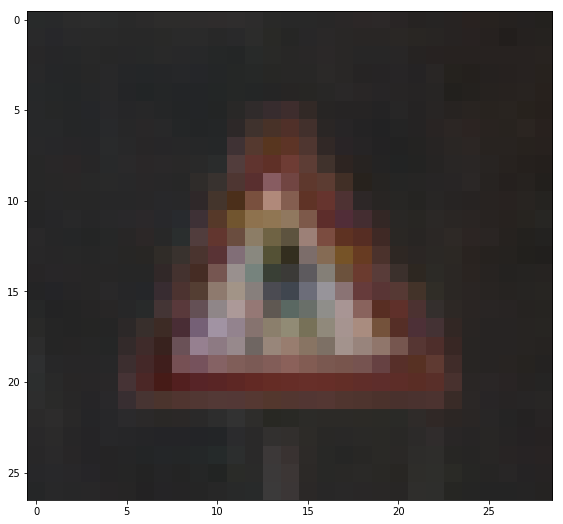

conv1 visualization


<Figure size 720x216 with 0 Axes>

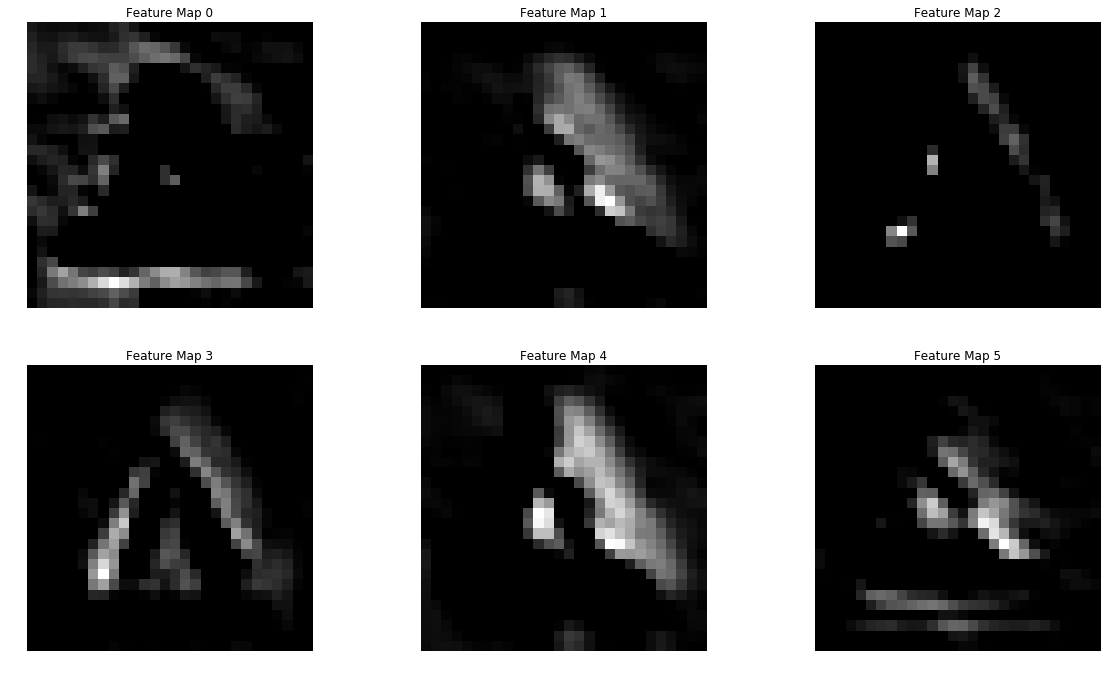

conv2 visualization


<Figure size 144x576 with 0 Axes>

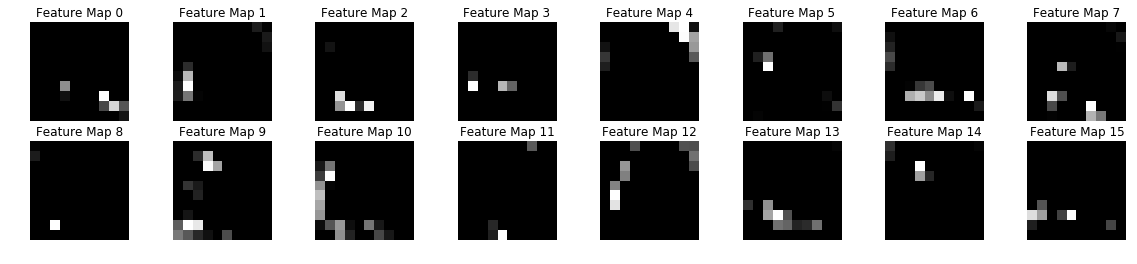

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


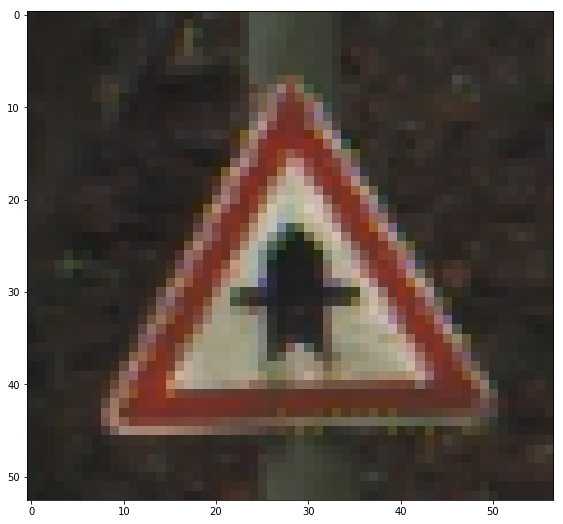

conv1 visualization


<Figure size 720x216 with 0 Axes>

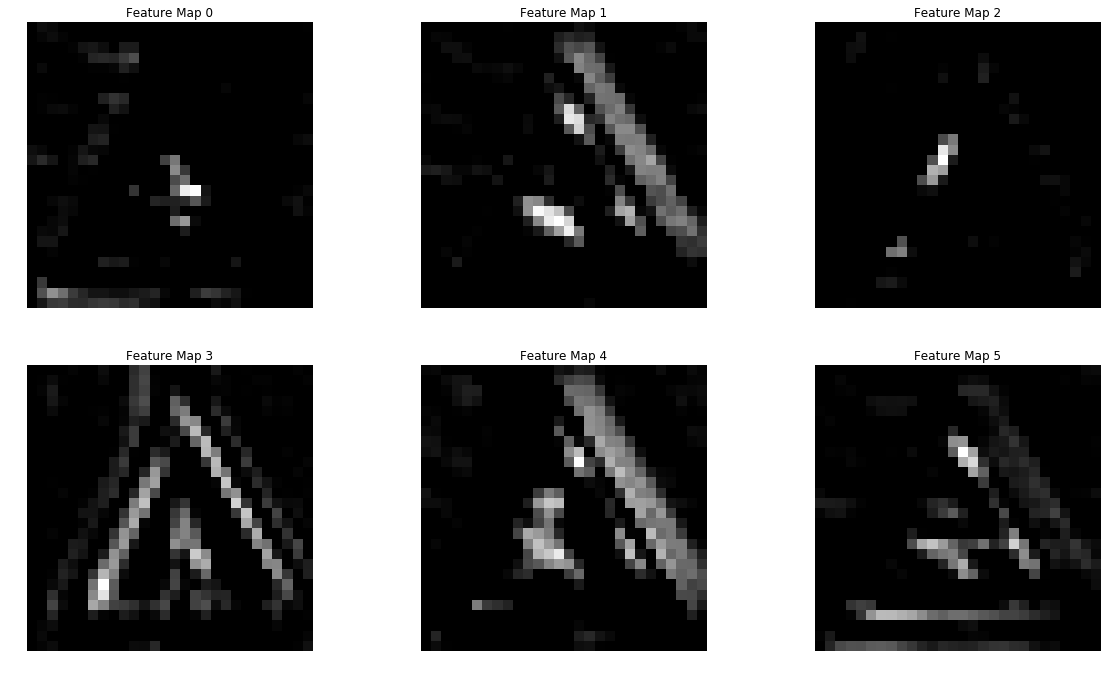

conv2 visualization


<Figure size 144x576 with 0 Axes>

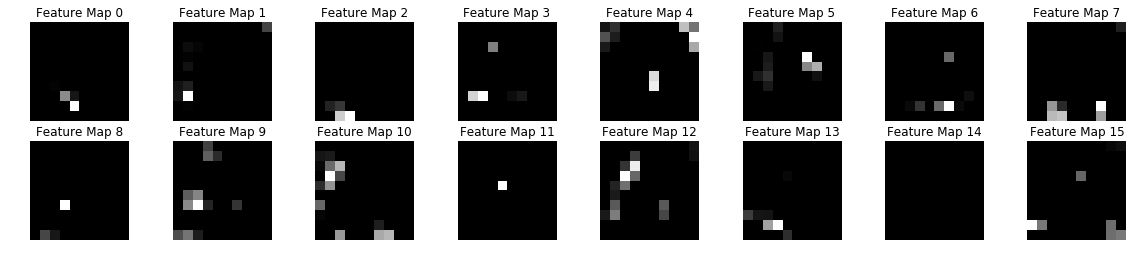

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


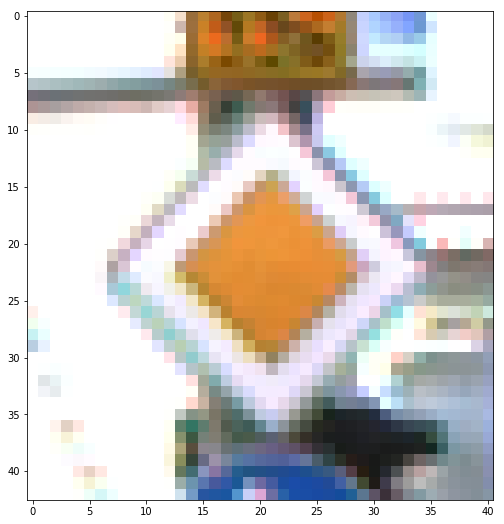

conv1 visualization


<Figure size 720x216 with 0 Axes>

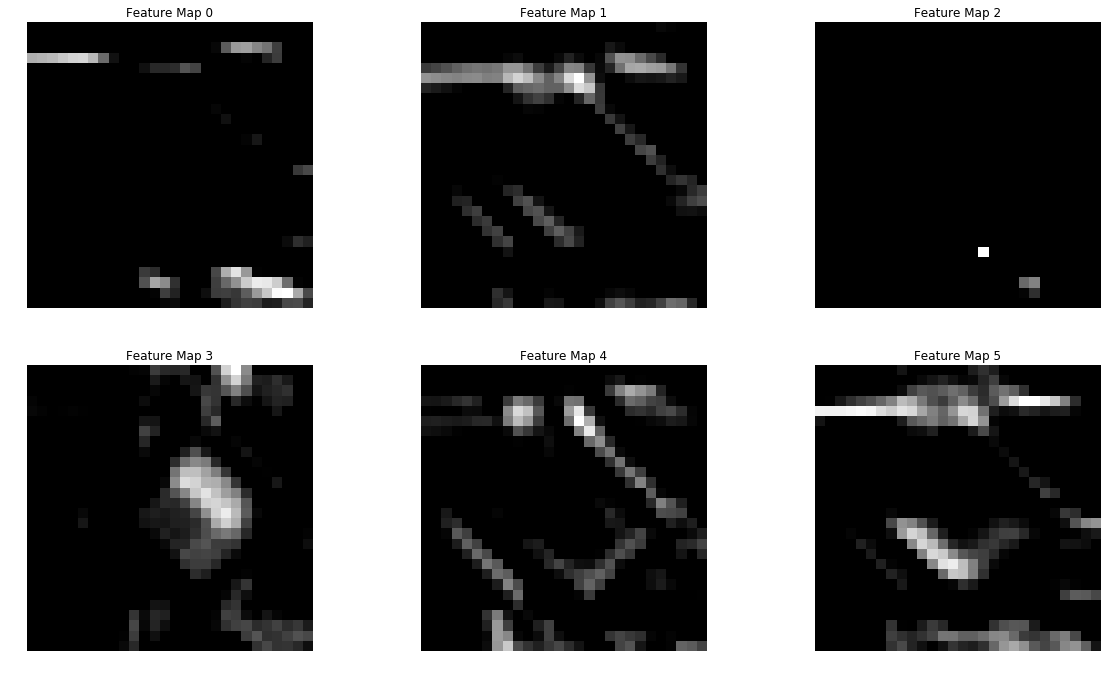

conv2 visualization


<Figure size 144x576 with 0 Axes>

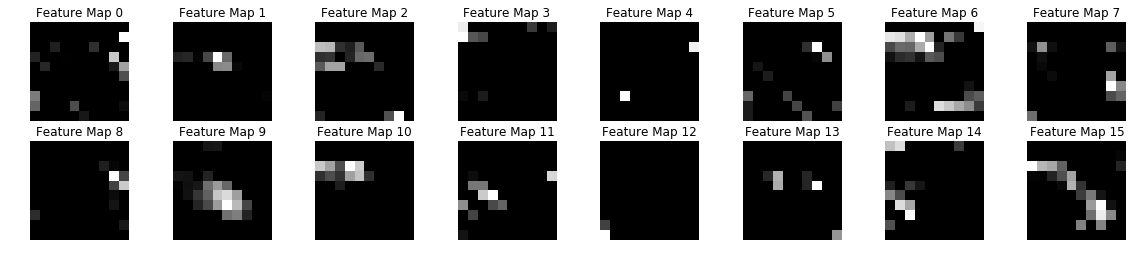

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


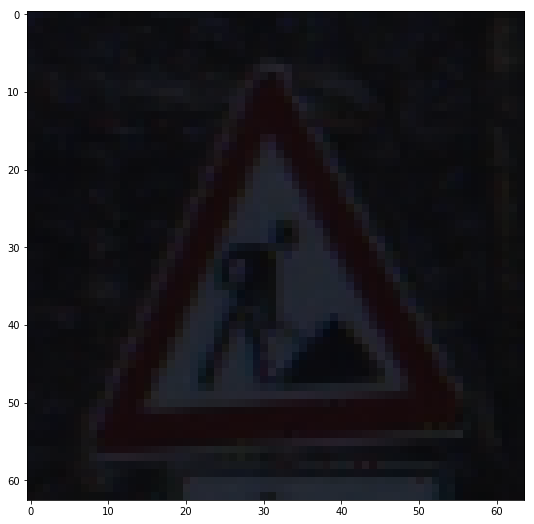

conv1 visualization


<Figure size 720x216 with 0 Axes>

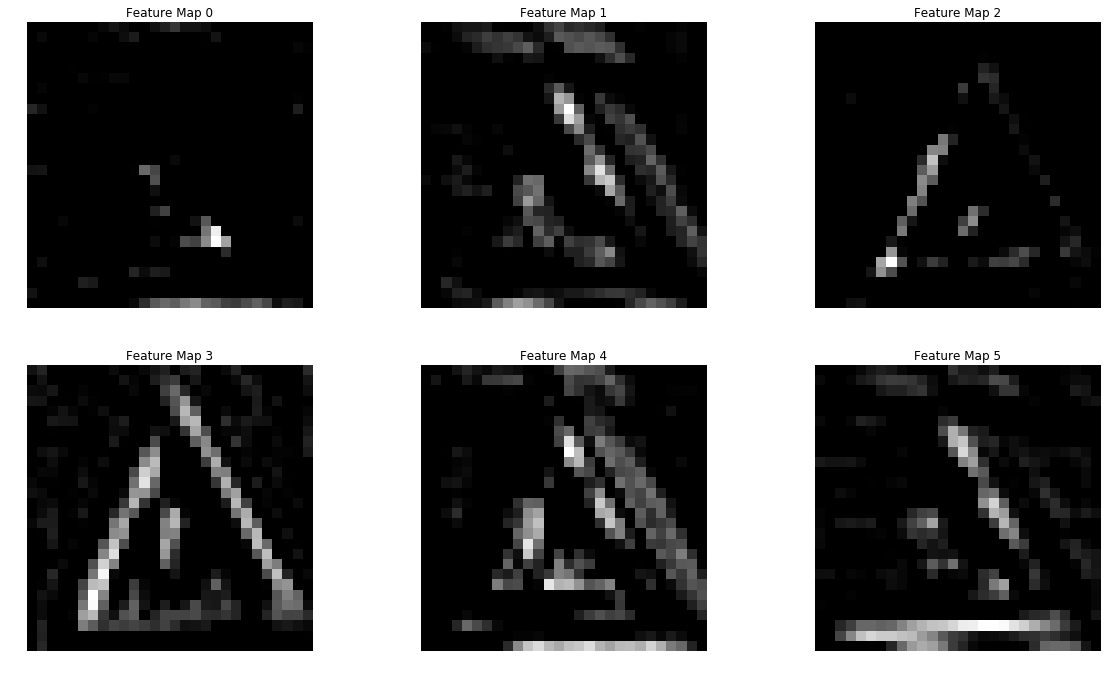

conv2 visualization


<Figure size 144x576 with 0 Axes>

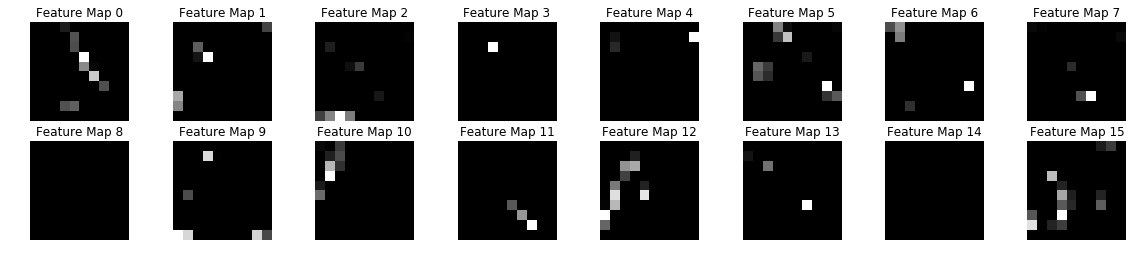

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


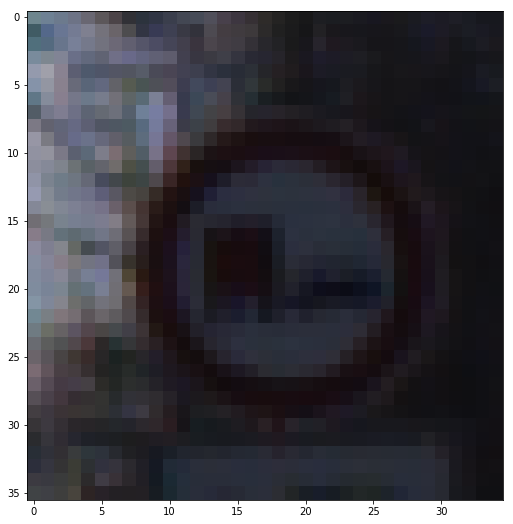

conv1 visualization


<Figure size 720x216 with 0 Axes>

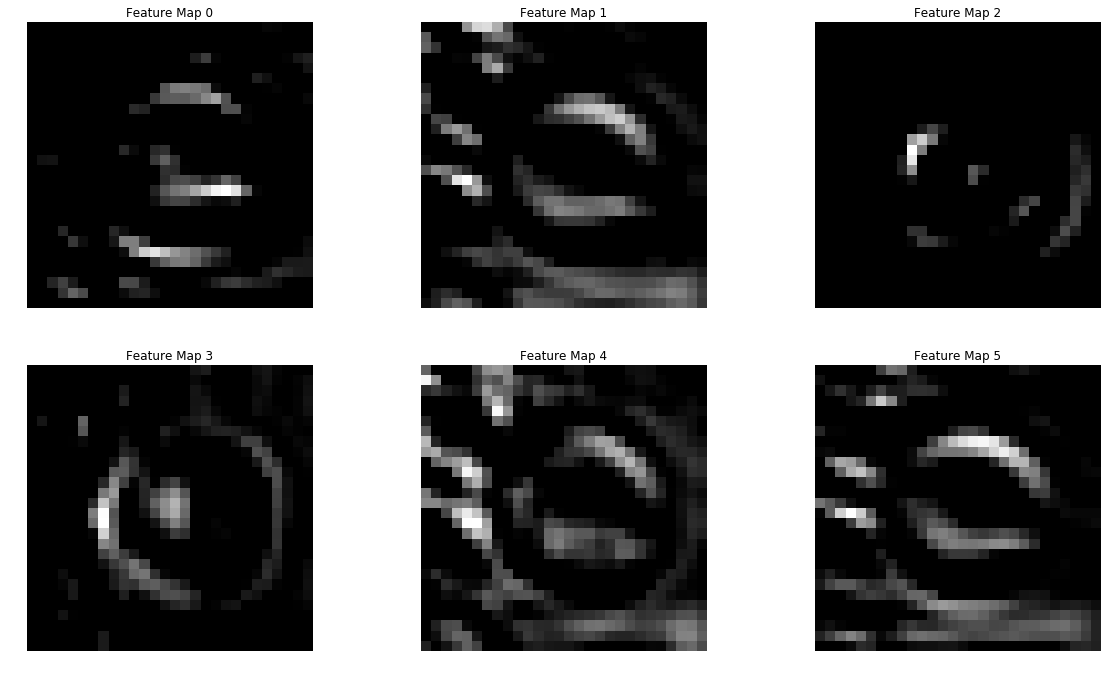

conv2 visualization


<Figure size 144x576 with 0 Axes>

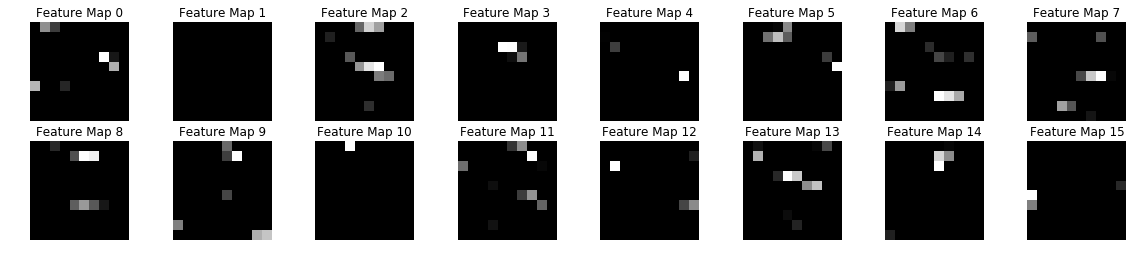

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [23]:
from skimage import io

N = 5
L = len(dataset["test"]["y"])

for _ in np.arange(N):
    num = np.random.randint(L)
    viz_db = {
        "X" : [],
        "y" : []
    }
    viz_db["X"].append(dataset["test"]["X"][num])
    viz_db["y"].append(dataset["test"]["y"][num])
    
    plt.imshow(io.imread(viz_db["X"][0]))
    plt.show()
    x_test, y_test = next(iter(covert_to_tf_dataset(viz_db, repeat = False)))
    
    print("conv1 visualization")
    visualize_conv_layer_out(get_intermediate_layer_output("conv1", x_test))
    
    print("conv2 visualization")
    visualize_conv_layer_out(get_intermediate_layer_output("conv2", x_test))
    
    print("-" * 200)